# Test Adaptive Regret
In this notebook, we test to ensure that our adaptive regret algorithm works well. We test against $k$-switching and slowly-changing linear dynamical systems.

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt

import numpy as np

from extravaganza.dynamical_systems import KSwitchingLTV

from extravaganza.lifters import Identity, NN
from extravaganza.system_models import LiftedController, OfflineSysid, HardFTH
from extravaganza.observables import FullObservation
from extravaganza.explorer import Explorer
from extravaganza.rescalers import FIXED_RESCALE, ADAM
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC, EvanBPC
from extravaganza.utils import ylim, render, summarize_lds, set_seed
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = 3
CONTROLLER_SEED = None
SYSID_SEED = None
# set_seed(0)

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmprlfyelil
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmprlfyelil/_remote_module_non_scriptable.py


In [11]:
disturbance_type = 'sinusoidal'

# --------------------------------------------------------------------------------------
# ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

num_trials = 1
T0 = 500
T = 12000  # total timesteps
reset_condition = lambda t: False # t % 1000 == 0  # how often to reset the system
use_multiprocessing = False
render_every = None

# --------------------------------------------------------------------------------------
# --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
# --------------------------------------------------------------------------------------

du = 2  # control dim
ds = 4  # state dim
k = 1
switch_every = 400000

cost_fn = 'quad'

make_system = lambda : KSwitchingLTV(ds, du, k, switch_every, disturbance_type, cost_fn, seed=SYSTEM_SEED)
observable = FullObservation(state_dim=ds)
do = observable.obs_dim

# --------------------------------------------------------------------------------------
# ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

h = 4  # controller memory length (# of w's to use on inference)
m_update_rescaler = lambda : ADAM(alpha=0.000, betas=(0.9, 0.999), use_bias_correction=True)
m0_update_rescaler = lambda : ADAM(alpha=0.000, betas=(0.9, 0.999), use_bias_correction=True)
k_update_rescaler = lambda : ADAM(alpha=0.001, betas=(0.9, 0.999), use_bias_correction=True)
# m_update_rescaler = lambda : FIXED_RESCALE(alpha=0.00)
# m0_update_rescaler = lambda : FIXED_RESCALE(alpha=0.01)
# k_update_rescaler = lambda : FIXED_RESCALE(alpha=0.00)

evan_bpc_args = {
    'h': h,  
    'method': 'REINFORCE',
    'initial_scales': (0, 0.05, 0),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
    'bounds': None,
    'initial_u': np.zeros(du),
    'decay_scales': False,
    'use_tanh': False,
    'use_stabilizing_K': True,
    'seed': CONTROLLER_SEED
}

# offline
def make_offline_controller(sys, name):
    explorer = Explorer(mean=np.zeros(du), std=0.1)
    def mc(dataset):
        lifter = Identity(do, du, normalize=False)
        lifter.train(dataset)
#         lifter = NN(do, du, dl, dl, 'learned', 4)
#         lifter.train(dataset, 8000, 256)
        Ahat, Bhat = lifter.AB['regression']
#         print(summarize_lds(Ahat, Bhat))
        
        if name == 'LQR': c = LQR(A=Ahat, B=Bhat)
        elif name == 'HINF': c = HINF(A=Ahat, B=Bhat, T=T)
        elif name == 'GPC': c = GPC(A=Ahat, B=Bhat, H=5, lr_scale=0.01, decay=True)
        elif name == 'BPC': c = BPC(A=Ahat, B=Bhat, H=h, lr_scale=0.01, decay=True, delta=0.001)
        elif name == 'RBPC': c = RBPC(A=Ahat, B=Bhat, M=h, lr=0.02, delta=0.001, noise_sd=0.025)
        elif name == 'Evan BPC': c = EvanBPC(A=Ahat, B=Bhat, **evan_bpc_args)
        else: raise NotImplementedError()
        return LiftedController(c, lifter)
    return OfflineSysid(du, do, explorer, mc, T0)

# adaptive
def make_adaptive_controller(sys, name):
    explorer = Explorer(mean=np.zeros(du), std=0.1)
    def mc(dataset):
        lifter = Identity(do, du, normalize=False)
        lifter.train(dataset)
#         lifter = NN(do, du, dl, dl, 'learned', 4)
#         lifter.train(dataset, 8000, 256)
        Ahat, Bhat = lifter.AB['regression']
#         print(summarize_lds(Ahat, Bhat))
        
        if name == 'LQR': c = LQR(A=Ahat, B=Bhat)
        elif name == 'HINF': c = HINF(A=Ahat, B=Bhat, T=T)
        elif name == 'GPC': c = GPC(A=Ahat, B=Bhat, H=5, lr_scale=0.01, decay=True)
        elif name == 'BPC': c = BPC(A=Ahat, B=Bhat, H=h, lr_scale=0.01, decay=True, delta=0.001)
        elif name == 'RBPC': c = RBPC(A=Ahat, B=Bhat, M=h, lr=0.02, delta=0.001, noise_sd=0.025)
        elif name == 'Evan BPC': c = EvanBPC(A=Ahat, B=Bhat, **evan_bpc_args)
        else: raise NotImplementedError()
        return LiftedController(c, lifter)
    return HardFTH(du, do, explorer, mc, eta=0.2, T0=T0, spawn_every=32, dataset_window=64, min_lifetime=128)


make_controllers = {
#     'offline Evan BPC': lambda sys: make_offline_controller(sys, 'Evan BPC'),
    'adaptive Evan BPC': lambda sys: make_adaptive_controller(sys, 'Evan BPC'),
    
    'LQR': lambda sys: LQR(A=sys.systems[0][0], B=sys.systems[0][1]),
#     'HINF': lambda sys: HINF(A=sys.A, B=sys.B, T=T, seed=CONTROLLER_SEED),
    'GPC': lambda sys: GPC(A=sys.systems[0][0], B=sys.systems[0][1], H=h, lr_scale=0.01, decay=True, seed=CONTROLLER_SEED),
#     'BPC': lambda sys: BPC(A=sys.A, B=sys.B, H=h, lr_scale=0.01, decay=True, delta=0.001, seed=CONTROLLER_SEED),
#     'RBPC': lambda sys: RBPC(A=sys.A, B=sys.B, M=h, lr=0.02, delta=0.001, noise_sd=0.05, seed=CONTROLLER_SEED),
}
experiment_args = {
    'make_system': make_system,
    'make_controllers': make_controllers,
    'observable': observable,
    'num_trials': num_trials,
    'T': T,
    'reset_condition': reset_condition,
    'reset_seed': None,
    'use_multiprocessing': use_multiprocessing,
    'render_every': render_every,
}

experiment = Experiment('')
experiment(**experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing adaptive Evan BPC
INFO: (EXPLORER) generating exploration control sequences using ['random', 'repeat', 'impulse'] w.p. [1. 0. 0.]


||A||_op = 0.9602849515885805
||B||_F = 2.4659064877340646
||A-BK||_op = 0.9670645796411811
eig(A) = [0.96028495 0.96028495 0.80928306 0.23106011]
svd(B) = [2.09316275 1.30359675]



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:33<00:00, 359.48it/s, control=[ 0.04598436 -0.01125034], cost=0.0136]
INFO: 
INFO: (EXPERIMENT): testing LQR


||A||_op = 0.9602849515885805
||B||_F = 2.4659064877340646
||A-BK||_op = 0.9670645796411811
eig(A) = [0.96028495 0.96028495 0.80928306 0.23106011]
svd(B) = [2.09316275 1.30359675]



 20%|█████████████████████████▎                                                                                                    | 2407/12000 [00:01<00:06, 1568.17it/s, control=[-0.118981    0.27577344], cost=0.902]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 8451/12000 [00:05<00:02, 1724.02it/s, control=[-0.00828752  0.02052412], cost=0.00536]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookA

||A||_op = 0.9602849515885805
||B||_F = 2.4659064877340646
||A-BK||_op = 0.9670645796411811
eig(A) = [0.96028495 0.96028495 0.80928306 0.23106011]
svd(B) = [2.09316275 1.30359675]



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:35<00:00, 340.02it/s, control=[-0.00288439 -0.00803398], cost=0.00205]
INFO: 
INFO: (EXPERIMENT) done! The entire experiment took 75.64145145891234 seconds


defaultdict(list,
            {'adaptive Evan BPC': <extravaganza.stats.Stats at 0x2e04b43d0>,
             'LQR': <extravaganza.stats.Stats at 0x2d2643a00>,
             'GPC': <extravaganza.stats.Stats at 0x2df3b8b50>})

<Figure size 640x480 with 0 Axes>

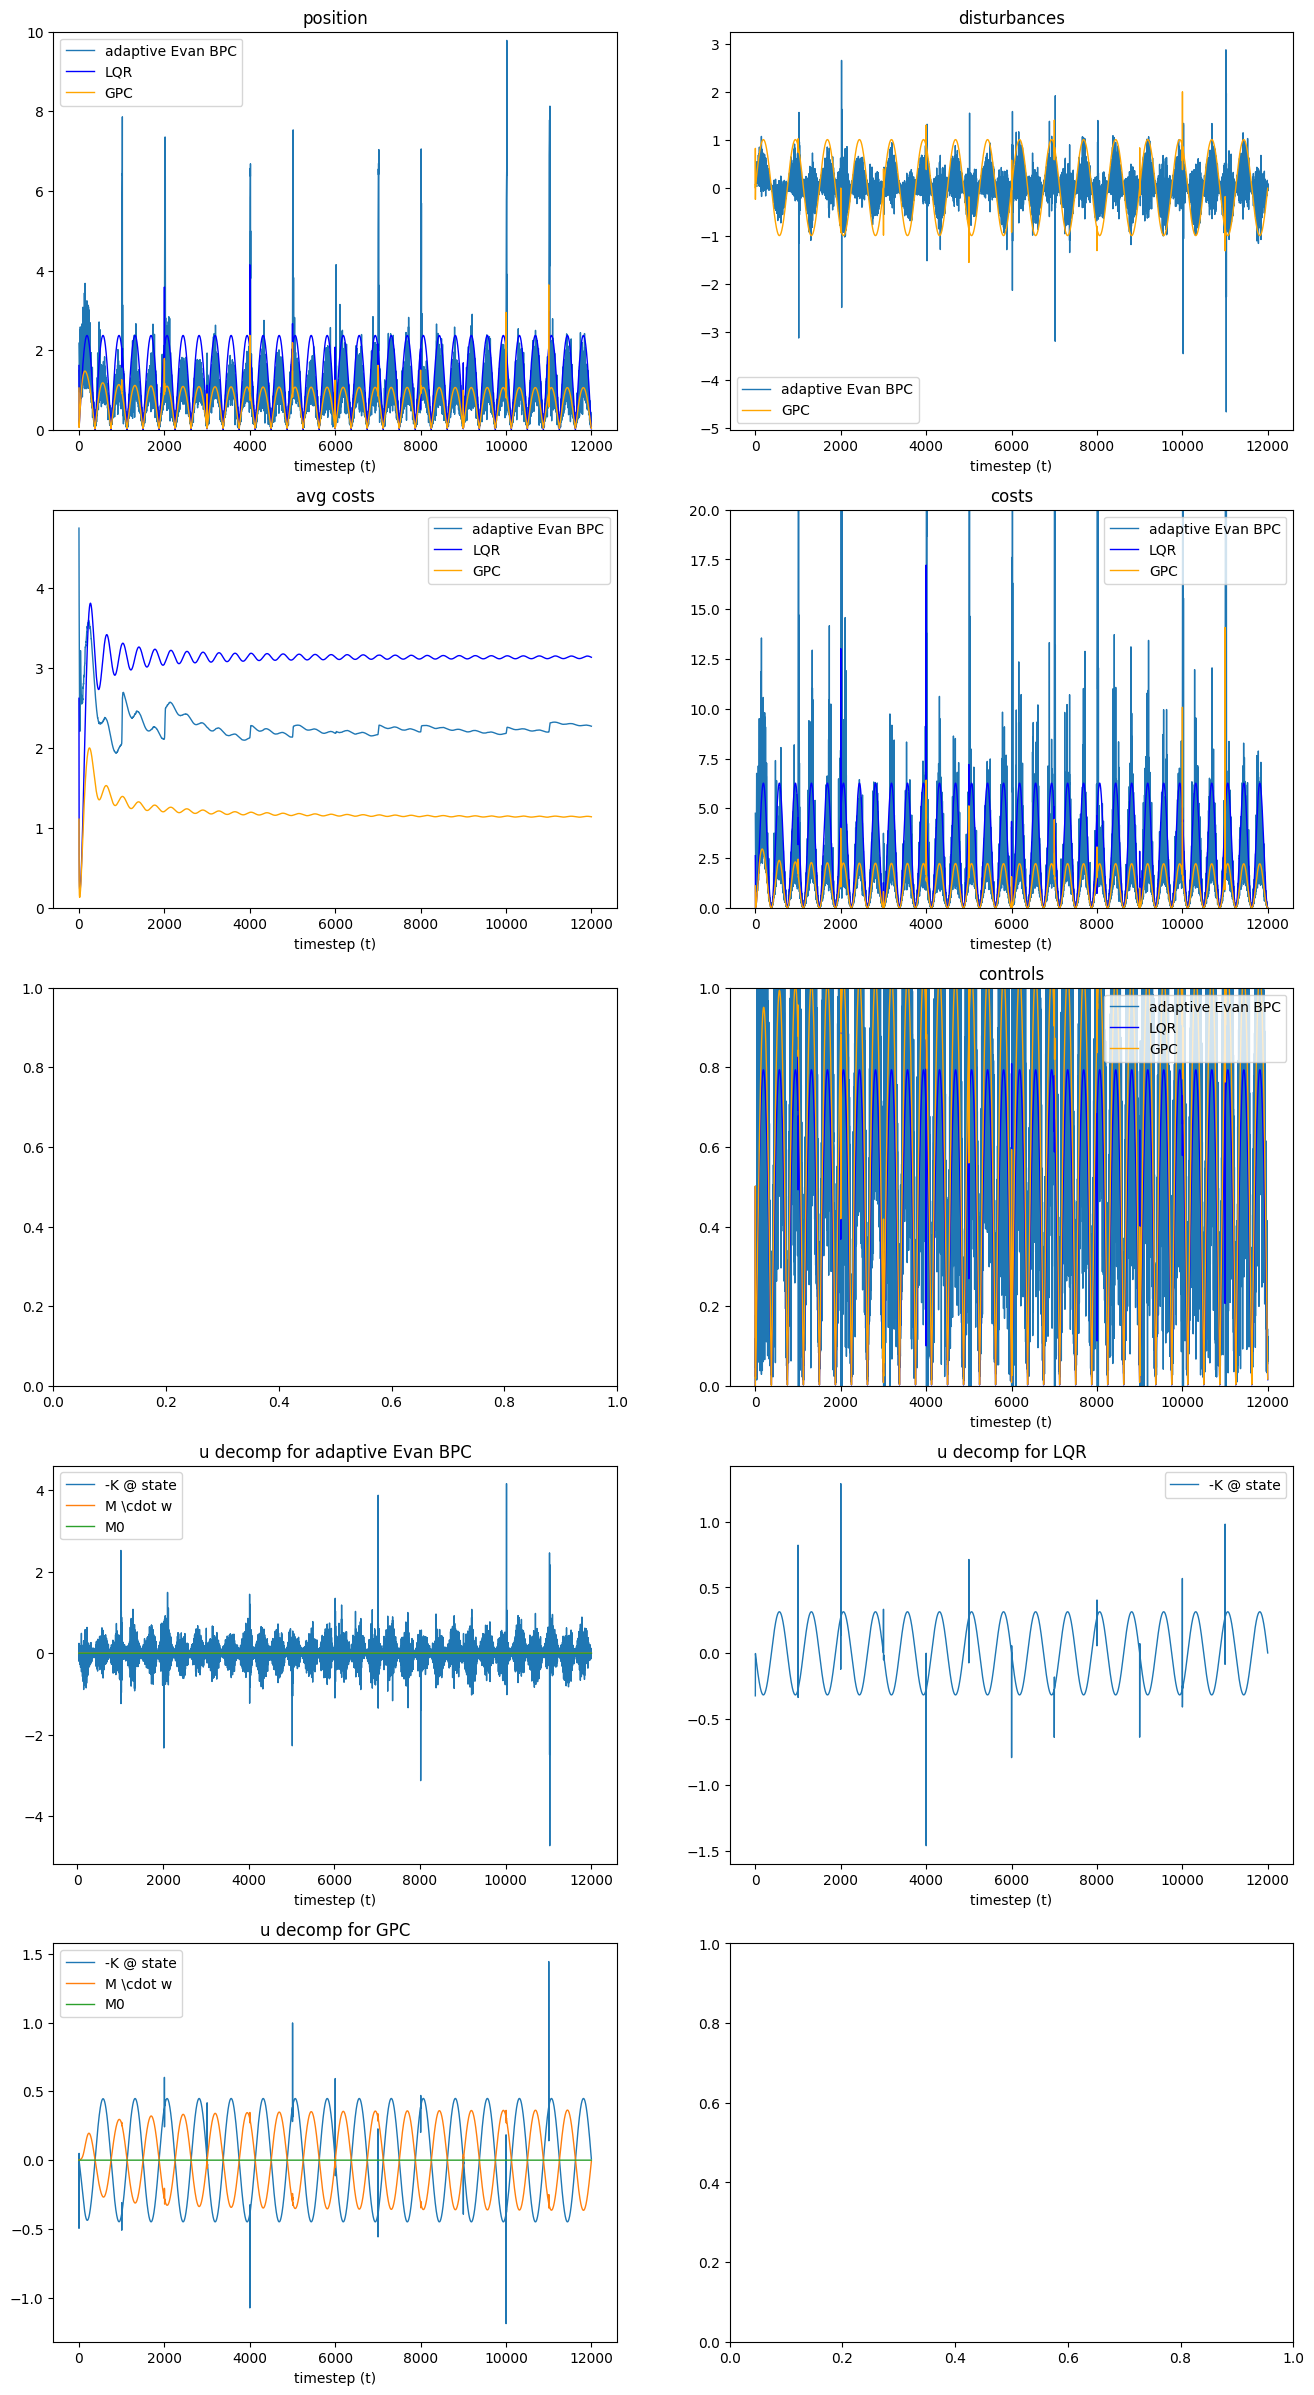

In [12]:
def plot_lds(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 3
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'true states', label=method, plot_norm=True)
        stats.plot(ax[2, 1], 'controls', label=method, plot_norm=True)
        stats.plot(ax[1, 0], 'costs', label=method, plot_cummean=True)
        stats.plot(ax[1, 1], 'costs', label=method)
    
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method, plot_idx=0)
        stats.plot(i_ax, '-K @ state', label='-K @ state', plot_idx=0)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=0)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=0)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend(); ylim(_ax, 0, 10)
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('avg costs'); _ax.legend(); ylim(_ax, 0, 20)
    _ax = ax[1, 1]; _ax.set_title('costs'); _ax.legend(); ylim(_ax, 0, 20)
    
    _ax = ax[2, 1]; _ax.set_title('controls'); _ax.legend(); ylim(_ax, 0, 1)
    pass
plot_lds(experiment)